small markdown to estimate a good THETA estimate (0.08) for ~ 10 different edges and to generate
the rloc matrices for all 3 subgroups/ as well as pickled true results

In [2]:
import sys
sys.path.insert(0, '../../helperScripts/')
from IDseqHelperFunctions import *

import scmra
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import pandas as pd
from datetime import datetime
import pickle
import seaborn as sns; sns.set_theme()
from matplotlib.pyplot import figure
import scmra
import itertools
import umap
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
#distribution of distances in cell space
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler

import random


def write_edge_subpopulation_differences(trueEdges, recoveredEdges, nameExtension):
    #WRITE ASLSO THE SEPERATE ANALYSES INTO A TSV FILE
    objectMasterResult = open(trueEdges, "rb")
    MASTERCNR = pickle.load(objectMasterResult) #the first solution, which edges we will take

    file = open(recoveredEdges,"rb")
    resultPermSimulations = pickle.load(file)

    #get all different edges
    colsToKeep = []
    for indicator, status in MASTERCNR.vardict.items():
        if(indicator.startswith(("IDev")) and status==1):
            indSplit = indicator.split("_")
            colsToKeep.append(indSplit[1] + "_" + indSplit[2])
    #subset these column now
    resultEdgePerm = []
    for i in resultPermSimulations:
        df = i[colsToKeep]
        resultEdgePerm.append(df)
    print(colsToKeep)

    #WRITE THE EDGE DIFFERENCES BETWEEN TREATMENT/PRB AND VEHICLE INTO A TSV
    cols = ["GROUP","EDGE","VALUE"]
    dfEdgeDiff = pd.DataFrame(columns = cols)
    for i in resultEdgePerm:
        colName = i.columns
        rowNames = i.index
        for col in colName:
            for row in rowNames:
                if(not row=="vehicle"):
                    arr = [row, col, i.loc["vehicle", col] - i.loc[row, col]]
                    dfEdgeDiff = pd.concat([dfEdgeDiff, pd.DataFrame([arr], columns=["GROUP","EDGE","VALUE"])], axis=0)

    dfEdgeDiff.to_csv("../bin/edgePermutationAnalysis" + nameExtension + ".tsv", sep="\t")

    #WRITE THE EDGE DIFFERENCES FORM MASTERCNR TO A TSV
    cols = ["GROUP","EDGE","VALUE"]
    truePoint = pd.DataFrame(columns = cols)
    populations = list(MASTERCNR.rloc.keys())
    populations.remove("vehicle")
    for edge in colsToKeep:
        for pop in populations:
            toFromList = edge.split("_")
            val = MASTERCNR.rloc["vehicle"].loc[toFromList[0], toFromList[1]] - MASTERCNR.rloc[pop].loc[toFromList[0], toFromList[1]]
            arr = [pop, edge, val]
            truePoint = pd.concat([truePoint, pd.DataFrame([arr], columns=["GROUP","EDGE","VALUE"])], axis=0)

    truePoint.to_csv("../bin/edgePermutationAnalysisTrueDifferences" + nameExtension + ".tsv", sep="\t")

def shuffle_group_label(group_annot):
    keys = list(group_annot.keys())
    keyValueNumber = {}
    valueList= []
    for key in keys:
        keyValueNumber[key] = len(group_annot[key])
        valueList.append(group_annot[key])

    valueList = [item for sublist in valueList for item in sublist]

    group_annot_return = {}
    assert(len(keys) == 2)
    group_annot_return[keys[0]] = random.sample(valueList, keyValueNumber[keys[0]])
    group_annot_return[keys[1]] = list(set(valueList) - set(group_annot_return[keys[0]]))

    return(group_annot_return)

def shuffle_group_label_3labels(group_annot):
    keys = list(group_annot.keys())
    keyValueNumber = {}
    valueList= []
    for key in keys:
        keyValueNumber[key] = len(group_annot[key])
        valueList.append(group_annot[key])

    valueList = [item for sublist in valueList for item in sublist]

    group_annot_return = {}
    assert(len(keys) == 3)
    group_annot_return[keys[0]] = random.sample(valueList, keyValueNumber[keys[0]])
    group_annot_return[keys[1]] = random.sample(list(set(valueList) - set(group_annot_return[keys[0]])), keyValueNumber[keys[1]])
    listSoFar = list(set(valueList) - set(group_annot_return[keys[0]]))
    listSoFar = list(set(listSoFar) - set(group_annot_return[keys[1]]))
    group_annot_return[keys[2]] = random.sample(listSoFar, keyValueNumber[keys[2]])

    return(group_annot_return)

def get_pairwise_distances(data, method = 'cosine', seperate_z_scale = False, minmax = False):
    def upper_tri_indexing(A):
        m = A.shape[0]
        r,c = np.triu_indices(m,1)
        return A[r,c]


    # Z-NORMALIZE DATA
    scaledForGroup = None
    if(seperate_z_scale and not minmax):
        for group in np.unique(data['treatment']):
            data_values = data[data['treatment'] == group].drop(['sample_id', 'treatment'], axis=1).values
            scaledForGroupAddon = StandardScaler().fit_transform(data_values)
            if(scaledForGroup is None):
                scaledForGroup = scaledForGroupAddon
            else:
                scaledForGroup = np.concatenate((scaledForGroup, scaledForGroupAddon), axis=0)
        data = scaledForGroup
    elif(not minmax):
        data_values = data.drop(['sample_id', 'treatment'], axis=1).values
        data = StandardScaler().fit_transform(data_values)

    if(minmax):
        data_values = data.drop(['sample_id', 'treatment'], axis=1).values
        scaler = MinMaxScaler()
        scaler.fit(data_values)
        data = scaler.transform(data_values)

    #EGF_DATA ROW=cell columns=FEATURES (cells in rows)
    #pairwiseDistances diagonal is zero, upper triangular matrix: row=from, col=to (dsitance of cell in row 0 to cell 9 is pairwise[0,9])
    pairwiseDistances = pairwise_distances(data, metric=method)
    
    #list: only to visualize distances (other than that not an interesting data structure)
    disList = upper_tri_indexing(pairwiseDistances)

    import matplotlib.pyplot as plt
    plt.hist(disList, bins=100)
    plt.show()

    return(pairwiseDistances)

def map_string_to_ints(stringList):
    mydict={}
    i = 0
    for item in stringList:
        if(i>0 and item in mydict):
            continue
        else:    
            i = i+1
            mydict[item] = i
    k=[]
    for item in stringList:
        k.append(mydict[item])
    return(k)

def plot_graph(data, subset = None, removeIsolates = True, threshold = 0.65, method = 'cosine', protein = 'JNK-p', treatmentColor = False,
                rescaleToGroup = False, labelBYRank = False, seperate_z_scale = False, subset_data = None, edgeMap = False):

    localData = data.copy()

    adjMat = get_pairwise_distances(localData, method = method, seperate_z_scale = seperate_z_scale)
    adjMat[adjMat > threshold] = 0

    G = nx.from_numpy_array(adjMat)
    G.edges(data=True)

    #remove isolate nodes, they r not useful for graph matching
    if(removeIsolates):
        G.remove_nodes_from(list(nx.isolates(G)))
        #components smaller than...
        theshold_cluster_size = 3
        for component in list(nx.connected_components(G)):
            if len(component)<theshold_cluster_size:
                for node in component:
                    G.remove_node(node)

    #get colour scheme
    plotData = localData.copy()

    plotData = plotData.reset_index()
    index = plotData.index

    color_map = []
    if(treatmentColor):
        for node in G:
            color_map.append(plotData['treatment'][node])
        color_map = map_string_to_ints(color_map)
        minVal = 1
        maxVal = len(np.unique(color_map))
    else:
        ranksPerGroup = {}
        if(rescaleToGroup):
            for group in subset:
                ranksPerGroup[group] = ss.rankdata(plotData[plotData['treatment'] == group][protein])
                plotData.loc[plotData['cluster_id'] == group, 'rank'] = ranksPerGroup[group]
            for node in G:
                color_map.append(plotData['rank'][node]) #bcs ranks are 1-based indexed
        else:  
            for node in G:
                color_map.append(plotData[protein][node])
                #MIN and MAX values are values in range of WHOLE dataset and not only subset to see differences
        minVal = np.min(plotData[protein])
        maxVal = np.max(plotData[protein])

    if(edgeMap):
        edge_map = []
        for node in G:
            edge_map.append(len(G.edges(node)))
        minVal = np.min(edge_map)
        maxVal = np.max(edge_map)
        meanEdge = np.mean(edge_map)
        removeNodes = []
        for node in G:
            if(len(G.edges(node)) < meanEdge/4):
                removeNodes.append(node)
        #remove node and calculte edge map new
        for node in removeNodes:
            G.remove_node(node)
        edge_map = []
        for node in G:
            edge_map.append(len(G.edges(node)))
            
        color_map = edge_map

    #treamtnt col overwriting edge color, so we can reduce edges but color by treatment :D 
    if(treatmentColor):
        color_map = []
        for node in G:
            color_map.append(plotData['treatment'][node])
        color_map = map_string_to_ints(color_map)
        minVal = 1
        maxVal = len(np.unique(color_map))

    labeldict = {}
    if(labelBYRank):
        for group in subset:
            ranksPerGroup = ss.rankdata(plotData[plotData['cluster_id'] == group][protein])
            plotData.loc[plotData['cluster_id'] == group, 'rank'] = ranksPerGroup

        keys = []
        vals = []
        for node in G:
            val = plotData['rank'][node]
            strVal = ""
            #if(val < 10 or val > 150):
            if(val):
                strVal = str(val)
            vals.append(strVal)
            keys.append(node)
        labeldict = dict(zip(keys,vals))


    #LRP6_P
    #NFKB_P65_P
    #RIBOSOMAL_S6_P
    fig,ax = plt.subplots(figsize=(15, 10), dpi=80)
    pos = nx.spring_layout(G, seed=225)  # Seed for reproducible layout
    nx.draw(G, pos, with_labels=True, labels=labeldict, node_size = 350, alpha = 0.7, cmap='viridis', node_color=color_map, vmin=minVal, vmax=maxVal)
    #nx.draw(G, pos, with_labels=False, node_size = 150, alpha = 0.5, cmap=plt.cm.Reds, node_color = edge_map)

    plt.show(fig)

    return G

def plot_3d(xs, ys, zs):  
    fig,ax = plt.subplots(figsize=(15, 10), dpi=80)
    ax = fig.add_subplot(projection='3d')
    n = 100
    ax.scatter(xs, ys, zs, s=80)

    ax.set_xlabel('DIM 1')
    ax.set_ylabel('DIM 2')
    ax.set_zlabel('DIM 3')

    plt.show()

def plot_net(dfData, threshold=0.6):
    import igraph as ig
    import leidenalg as la

    adjMat = get_pairwise_distances(dfData, method = "cosine")

    adjMat[adjMat > threshold] = 0
    adjMat[adjMat > 0] = 1

    adjMat = np.asmatrix(adjMat)
    G = ig.Graph.Adjacency(adjMat)
    #make an edge list with weights for Leiden clustering
    partition = la.find_partition(G, la.ModularityVertexPartition,n_iterations=20)#, weights = weightVec)

    #label the cluster name
    partitionVec = []
    clusterDict = {}
    pNum = (0)
    for p in partition:
        if(len(p) < 5): continue
        curList = []
        for node in p:
            curList.append(str(node))
            clusterDict[node] = str(pNum)
        partitionVec.append((curList))
        pNum += 1
    tmp = dfData.copy()
    tmp.reset_index(inplace=True)
    tmp = tmp.rename(columns = {'index':'ab_name'})
    x = tmp["ab_name"].map(clusterDict)

    ig.plot(partition, vertex_label = x, seed = 1) 

normalizedDataFile = "./IDSEQ_EGFRINH_NORMALIZED.tsv"
data = pd.read_csv(normalizedDataFile, sep='\t')

#subset the data
dataOrigionalNormalized = data[data["ab_name"].isin(ab_use)]
#data.head()

TODO:

- remove nodes that have no edges
- make eta range tets for all cells at the same time...

In [3]:
%%capture
#ESTIMATE THE RIGHT THETA
clusteredData = pd.read_csv("../bin/EGFRInhibitionDataProcessed.tsv", sep = "\t")

etaRange = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
etaRange = [0.8, 0.85, 0.9]

errorList = dict()
numberEdges = dict()

#RUN MRA for both GROUPS, and add edges
groupDict = prepare_data_for_separate_MRAs(clusteredData)

groups = groupDict.keys()
groups = ["AG1478"]

for group in groups:

    rDict = groupDict[group]
    errorListTmp = []
    numberEdgesTmp = []

    for eta in etaRange:
        rglob = rDict["glob"]
        rtot = rDict["tot"]

        cell_annot = None
        tx_annot = None
        group_annot = None

        #esrtimate ALPHA
        scd = scmra.ScData(rglob=rglob, rtot = rtot)
        ALPHA = scmra.sccplex.estimate_alpha(scd)

        scp = scmra.ScMraProblem(scd, eta=eta, alpha=ALPHA)
        scmra.sccplex.set_interactions_status(scp, CANNONICAL_EDGES, 1)
        scmra.sccplex.set_interactions_status(scp, OUTPUT_EDGES, 0)
        scmra.sccplex.set_interactions_status(scp, INPUT_EDGES, 0)
        scp.cpx.solve()
        s = scmra.ScMraResult(scp)

        #make MRA simulation
        #scd = scmra.ScData(rglob=rglob, rtot = rtot)
        #p = scmra.ScMraProblem(scd, prior_network = CANNONICAL_EDGES)
        #p.cpx.solve()
        #s = scmra.ScMraResult(p)

        n_res = np.size(s.residuals_complete) + np.size(s.residuals_incomplete)
        error = 0
        error += np.sum(np.array(np.square(s.residuals_complete)))/n_res
        error += np.sum(np.array(np.square(s.residuals_incomplete)))/n_res
        errorListTmp.append(error)

        var_names = scp.cpx.variables.get_names()
        vars_lst = [var for var in var_names if var.startswith('I_')]
        var_vals = scp.cpx.solution.pool.get_values(0, vars_lst)
        lengthIdcs = (np.count_nonzero(var_vals))
        numberEdgesTmp.append(lengthIdcs)

    errorList[group] = errorListTmp
    numberEdges[group] = numberEdgesTmp

with open('errorlist.pickle', 'wb') as handle:
    pickle.dump(errorList, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('numberEdges.pickle', 'wb') as handle:
    pickle.dump(numberEdges, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [6]:
print(errorlist.keys())
print(len(CANNONICAL_EDGES))

print(numberEdgesMUT)
print(etaRange)
print(errorsMUT)

dict_keys(['AG1478'])
56
[56, 56, 56]
[0.8, 0.85, 0.9]
[0.03494300419286232, 0.0349430041930388, 0.03494300419303879]


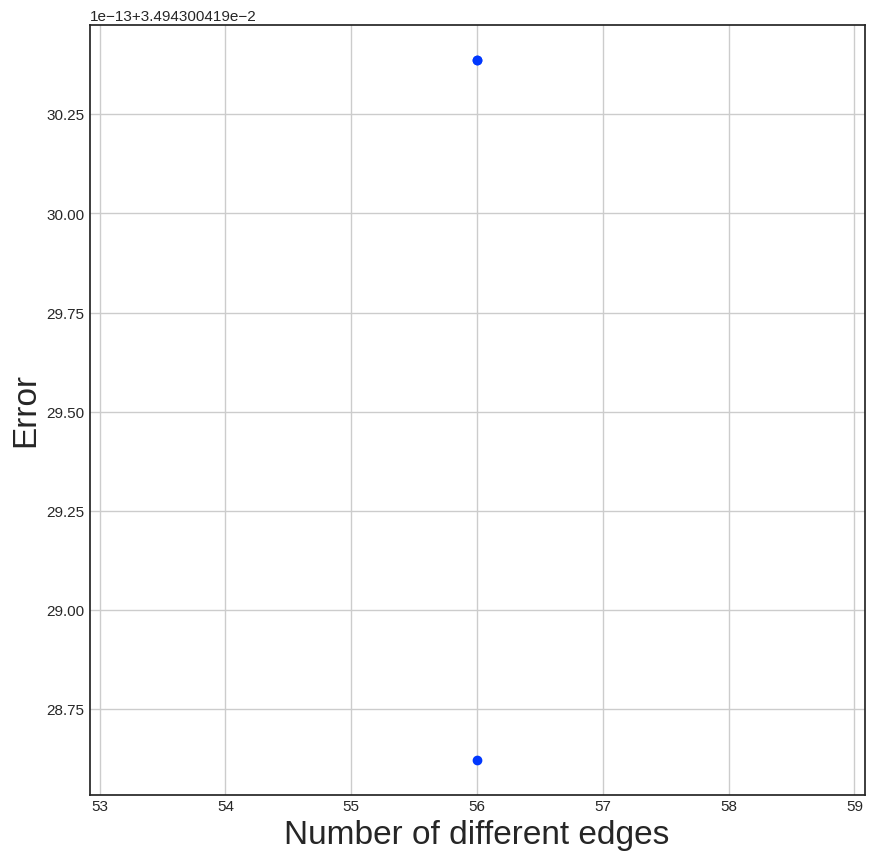

In [8]:
with open(r"errorlist.pickle", "rb") as input_file:
    errorlist = pickle.load(input_file)

with open(r"numberEdges.pickle", "rb") as input_file:
    numberEdges = pickle.load(input_file)

#errorsWT = errorlist["vehicle"]
#numberEdgesWT = numberEdges["vehicle"]

errorsMUT = errorlist["AG1478"]
numberEdgesMUT = numberEdges["AG1478"]

'''with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    f, ax = plt.subplots(figsize=(10, 10))
    wt = ax.scatter(numberEdgesWT, errorsWT, color = "#0138FE", s = 150)
    ax.plot(ls="--", c=".3")
    plt.xlabel('Number of different edges', size = 24)
    plt.ylabel('Error', size = 24)
    plt.show()
'''
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    f, ax = plt.subplots(figsize=(10, 10))
    wt = ax.scatter(numberEdgesMUT, errorsMUT, color = "#0138FE", s = 150)
    ax.plot(ls="--", c=".3")
    plt.xlabel('Number of different edges', size = 24)
    plt.ylabel('Error', size = 24)
    plt.show()



GENERATE ONLY ONE SINGLE MRA

At an eta of 0.3 we have roughly 65 edges in the network (56 in the origional one)

=> get those edges out and add them to CANONICAL_EDGES for scCNR reconstruction


In [9]:
%%capture
clusteredData = pd.read_csv("../bin/EGFRInhibitionDataProcessed.tsv", sep = "\t")
eta = 0.72

#RUN MRA for both GROUPS, and add edges
rDict = prepare_data_for_one_MRA(clusteredData)

edgesList = []
valueList = []

rglob = rDict["glob"]
rtot = rDict["tot"]

cell_annot = None
tx_annot = None
group_annot = None

#esrtimate ALPHA
scd = scmra.ScData(rglob=rglob, rtot = rtot)
ALPHA = scmra.sccplex.estimate_alpha(scd)

scp = scmra.ScMraProblem(scd, eta=eta, alpha=ALPHA)
scmra.sccplex.set_interactions_status(scp, CANNONICAL_EDGES, 1)
scmra.sccplex.set_interactions_status(scp, OUTPUT_EDGES, 0)
scmra.sccplex.set_interactions_status(scp, INPUT_EDGES, 0)
scp.cpx.solve()
s = scmra.ScMraResult(scp)

var_names = scp.cpx.variables.get_names()
vars_lst = [var for var in var_names if var.startswith('I_')]
var_vals = scp.cpx.solution.pool.get_values(0, vars_lst)

edgesList = vars_lst
valueList = var_vals

In [10]:
edges = edgesList
vals = valueList

new_edges = []
for i in range(0,len(vals)):
    if(vals[i] == 1):
        new_edges.append(edges[i])

indicator_lst = ['_'.join(['I', n_i, n_j]) for n_i, n_j in CANNONICAL_EDGES]
new_edges = [x for x in new_edges if x not in indicator_lst]

print(len(indicator_lst))

print(new_edges)

56
['I_JNK_CREB', 'I_RB_RELA', 'I_RB_p90RSK', 'I_RB_GSK3B', 'I_RB_STAT1']
